In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
import shap
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier

In [54]:
df = pd.read_csv('patient_data.csv')

# Problem List
- Imbalanced: rs9282541, rs4988235, rs9374842

# Data Overview

In [55]:
df.head(10)

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease
0,0,0,0,0,0,0,28.607859,0
1,0,0,1,1,0,0,26.651948,0
2,1,1,1,0,0,1,31.885502,0
3,0,0,1,0,0,0,29.353686,0
4,1,1,0,0,0,0,33.630251,0
5,0,0,0,0,0,0,28.243031,0
6,1,0,1,0,0,0,21.634838,0
7,1,1,1,1,0,0,36.809607,1
8,0,0,0,0,0,1,23.471339,0
9,0,0,0,0,1,1,23.231168,0


In [56]:
df.describe()

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.433333,0.326667,0.490000,0.316667,0.286667,0.276667,28.899291,0.113333
std,0.496364,0.469778,0.500735,0.465953,0.452960,0.448098,5.171930,0.317529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.798057,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.292649,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.185791,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.131210,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,44.188743,1.000000


# Data Visualisation

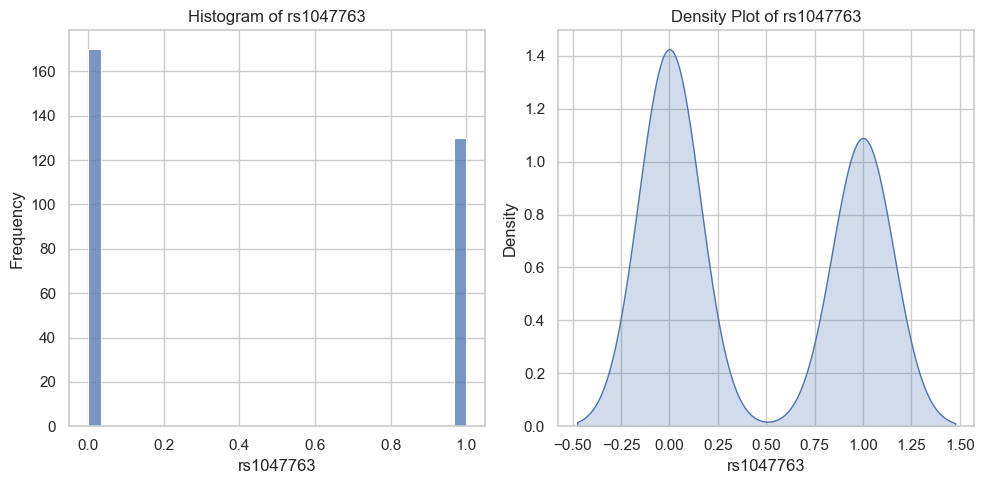

Statistics for rs1047763:
count    300.000000
mean       0.433333
std        0.496364
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs1047763, dtype: float64

Skewness: 0.27042311550799364

Kurtosis: -1.9398485446649685




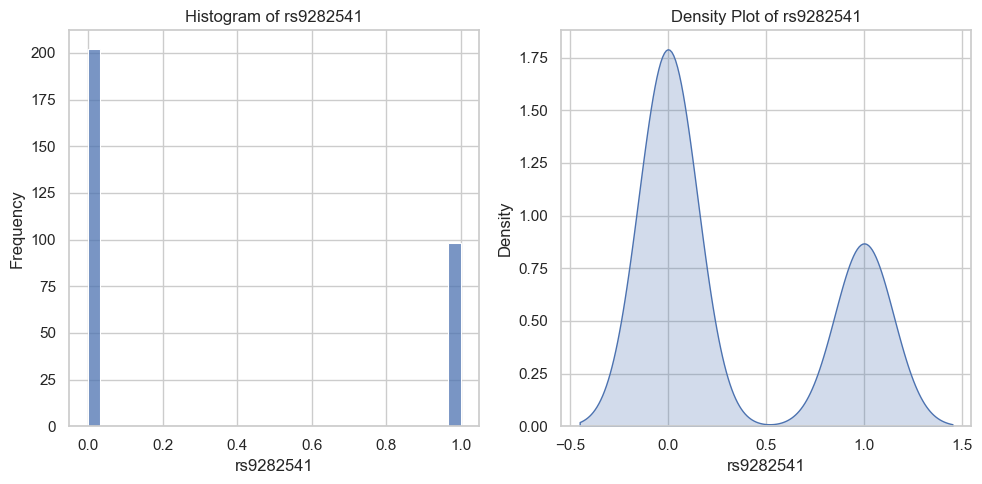

Statistics for rs9282541:
count    300.000000
mean       0.326667
std        0.469778
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs9282541, dtype: float64

Skewness: 0.7428901057135338

Kurtosis: -1.457878290225955




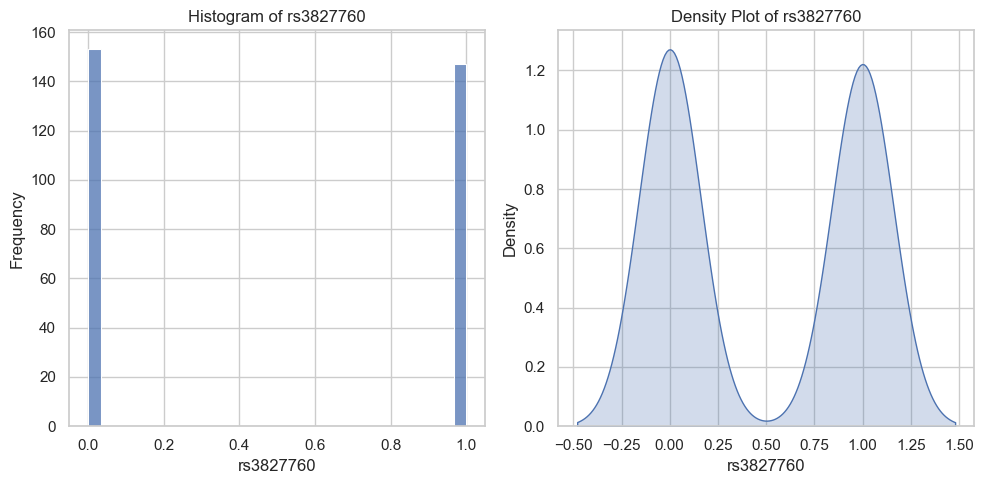

Statistics for rs3827760:
count    300.000000
mean       0.490000
std        0.500735
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs3827760, dtype: float64

Skewness: 0.04020932893019238

Kurtosis: -2.0118403721509397




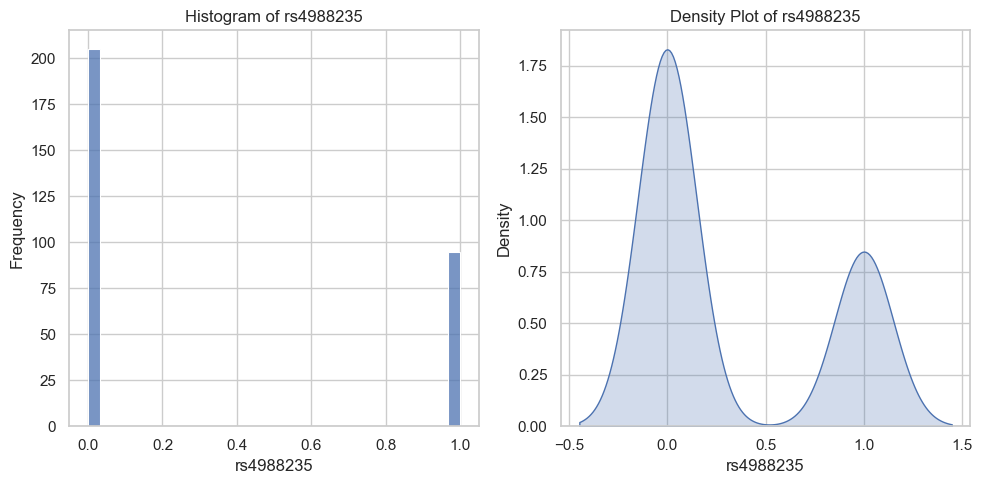

Statistics for rs4988235:
count    300.000000
mean       0.316667
std        0.465953
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs4988235, dtype: float64

Skewness: 0.7921983060685176

Kurtosis: -1.3816778288524028




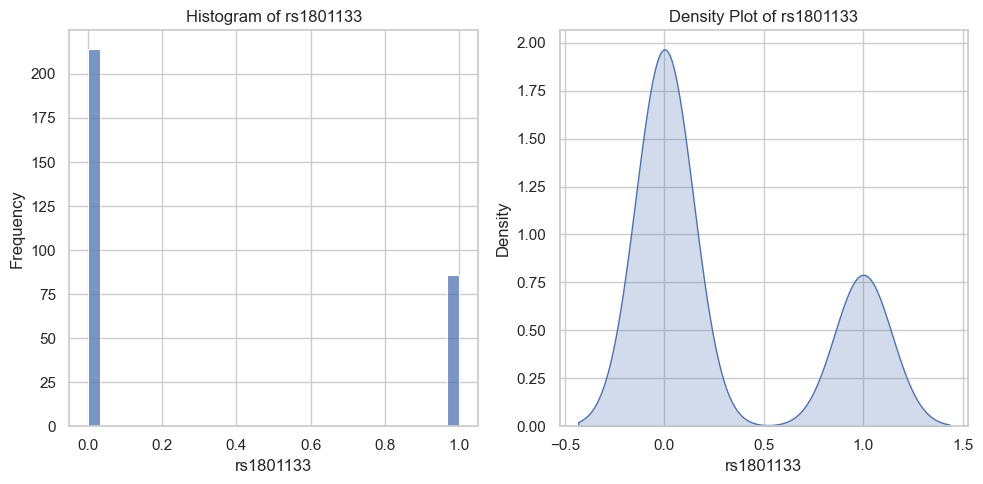

Statistics for rs1801133:
count    300.000000
mean       0.286667
std        0.452960
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs1801133, dtype: float64

Skewness: 0.9482739381272258

Kurtosis: -1.1082093594795097




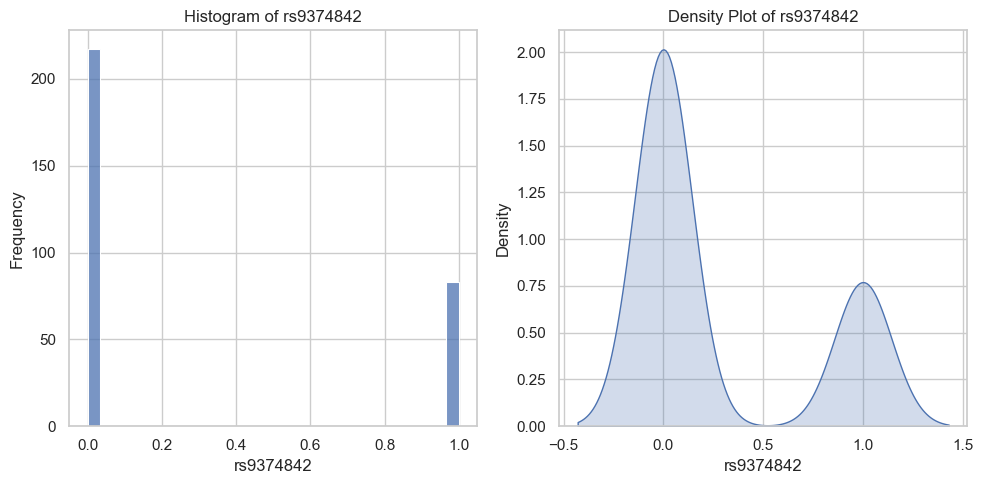

Statistics for rs9374842:
count    300.000000
mean       0.276667
std        0.448098
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rs9374842, dtype: float64

Skewness: 1.0034964551888386

Kurtosis: -0.999704302458511




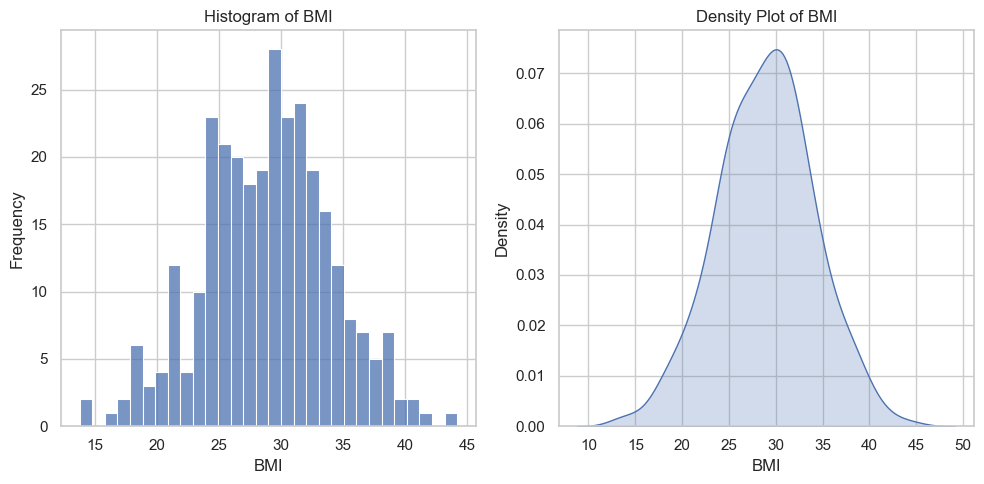

Statistics for BMI:
count    300.000000
mean      28.899291
std        5.171930
min       13.798057
25%       25.292649
50%       29.185791
75%       32.131210
max       44.188743
Name: BMI, dtype: float64

Skewness: -0.07151502280047747

Kurtosis: 0.04432978973014334




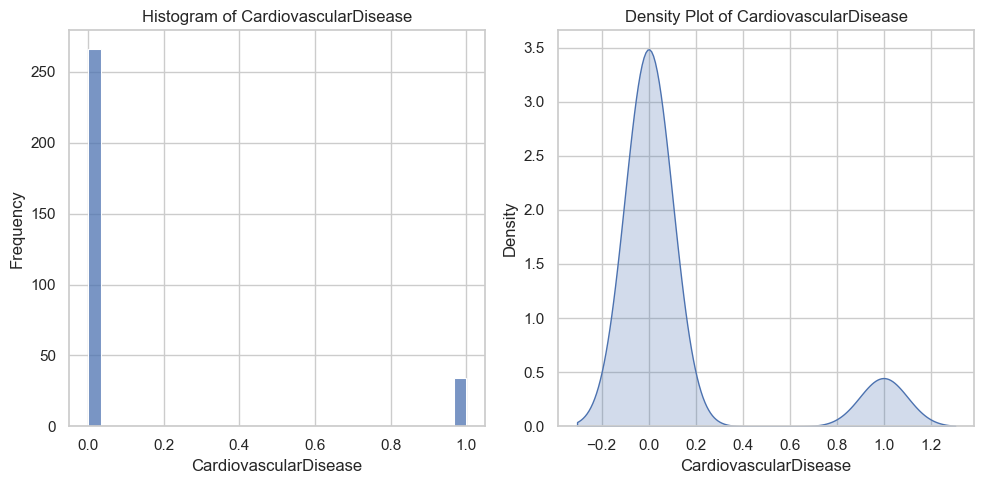

Statistics for CardiovascularDisease:
count    300.000000
mean       0.113333
std        0.317529
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: CardiovascularDisease, dtype: float64

Skewness: 2.451814818249953

Kurtosis: 4.0382737340785795




In [57]:
import seaborn as sns

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions
plot_distributions(df)


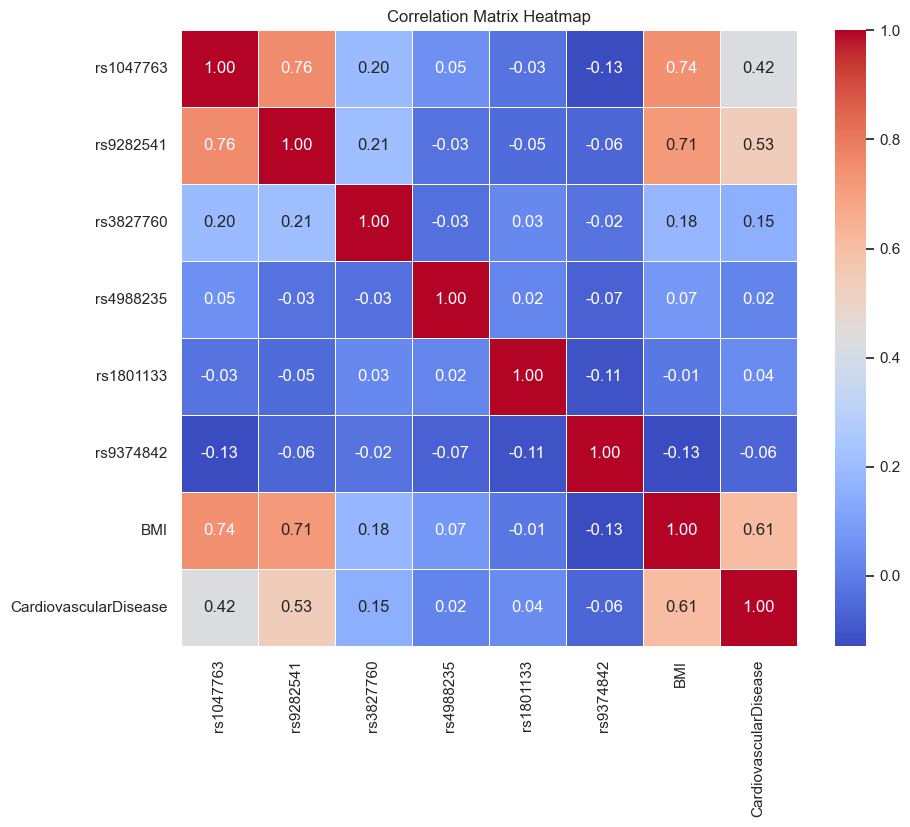

In [58]:
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Train-Test Split, TPOT

In [59]:

# Assume the target variable is named 'target'. Change it to your target column name
X = df.drop(columns=['CardiovascularDisease'])
y = df['CardiovascularDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Export the test set to a CSV file
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv('test_set.csv', index=False)

# Remove the test set from the dataframe
data = pd.concat([X_train, y_train], axis=1)

# Step 5: Use TPOT to find the best model
# Initialize TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit TPOT on the training data
tpot.fit(X_train, y_train)

# Export the best model pipeline code
tpot.export('tpot_best_model.py')

# Evaluate the best model on the test set
score = tpot.score(X_test, y_test)
print(f'Test Accuracy: {score:.4f}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9958333333333332

Generation 2 - Current best internal CV score: 0.9958333333333332

Generation 3 - Current best internal CV score: 0.9958333333333332

Generation 4 - Current best internal CV score: 0.9958333333333332

Generation 5 - Current best internal CV score: 0.9958333333333333

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.9500000000000001, min_samples_leaf=15, min_samples_split=2, n_estimators=100)
Test Accuracy: 1.0000


In [60]:
tpot_data = data.copy()
features = tpot_data.drop('CardiovascularDisease', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['CardiovascularDisease'], random_state=42)

# Average CV score on the training set was: 0.9958333333333333
exported_pipeline = RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.9500000000000001, min_samples_leaf=15, min_samples_split=2, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [61]:
# computing the predicted y for the whole df 
y_pred = exported_pipeline.predict(X)
y_pred_test = exported_pipeline.predict(X_test)
#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

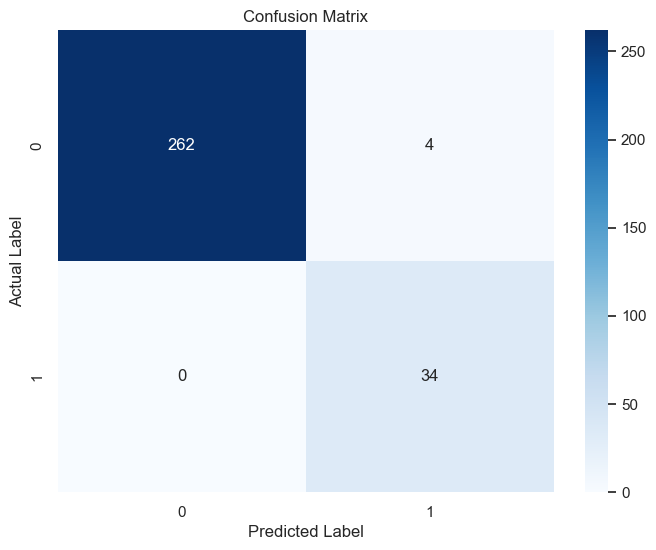

In [62]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [63]:
print(classification_report(y_test, y_pred_test, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       1.00      0.98      0.99        54
     Present       0.86      1.00      0.92         6

    accuracy                           0.98        60
   macro avg       0.93      0.99      0.96        60
weighted avg       0.99      0.98      0.98        60



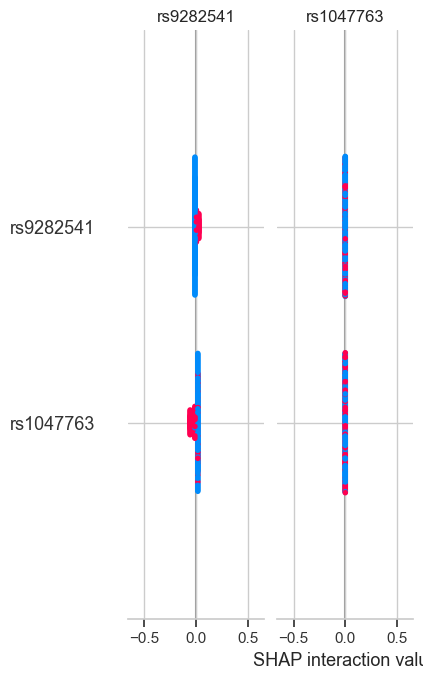

In [64]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(exported_pipeline, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot for all features
shap.summary_plot(shap_values, X, plot_type="bar")
plt.show()

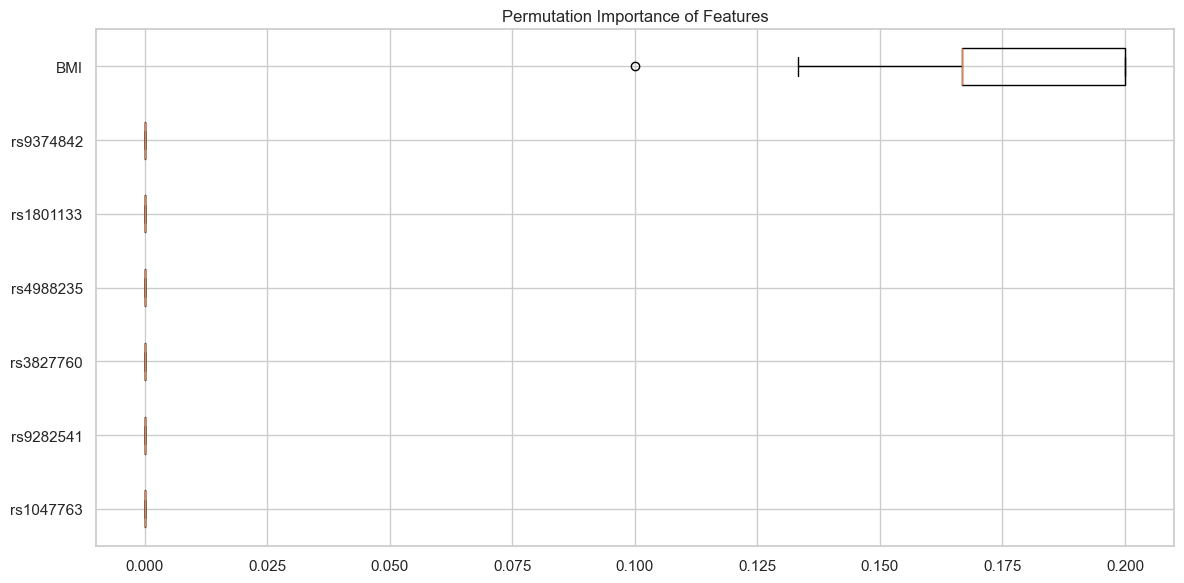

In [67]:
result = permutation_importance(exported_pipeline, X_test, y_test, n_repeats=10, random_state=42)
sorted = result.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.boxplot(result.importances[sorted].T, vert=False, labels=X_test.columns[sorted])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



# Dropping BMI

In [68]:
X_train = X_train.drop(columns=['BMI'])
X_test = X_test.drop(columns=['BMI'])

In [72]:
data= data.drop(columns=['BMI'])

In [70]:
tpot_noBMI = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit TPOT on the training data
tpot_noBMI.fit(X_train, y_train)

# Export the best model pipeline code
tpot_noBMI.export('tpot_best_model.py')

# Evaluate the best model on the test set
score_noBMI = tpot_noBMI.score(X_test, y_test)
print(f'Test Accuracy: {score_noBMI:.4f}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8958333333333333

Generation 2 - Current best internal CV score: 0.8958333333333333

Generation 3 - Current best internal CV score: 0.8958333333333333

Generation 4 - Current best internal CV score: 0.8958333333333333

Generation 5 - Current best internal CV score: 0.8958333333333333

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
Test Accuracy: 0.9000


In [76]:

tpot_data_noBMI = data.copy()
features = tpot_data_noBMI.drop('CardiovascularDisease', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data_noBMI['CardiovascularDisease'], random_state=42)

# Average CV score on the training set was: 0.8958333333333333
exported_pipeline = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [78]:
X = X.drop(columns=['BMI'])

In [79]:
# computing the predicted y for the whole df 
y_pred = exported_pipeline.predict(X)
y_pred_test = exported_pipeline.predict(X_test)
#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

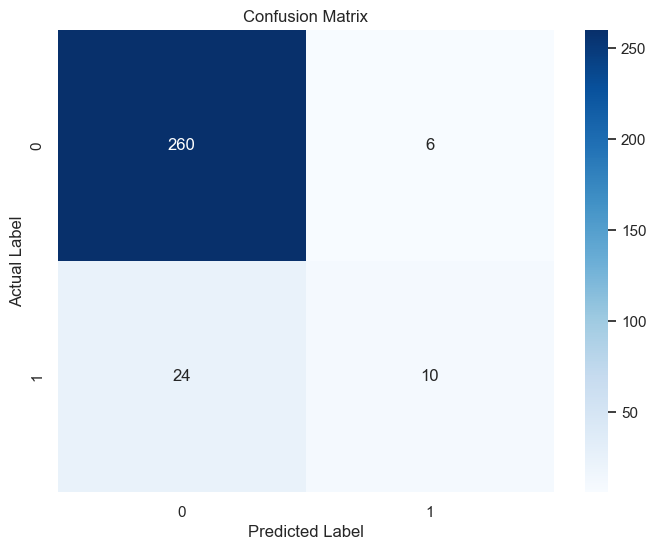

In [80]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [81]:
print(classification_report(y_test, y_pred_test, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       0.91      0.96      0.94        54
     Present       0.33      0.17      0.22         6

    accuracy                           0.88        60
   macro avg       0.62      0.56      0.58        60
weighted avg       0.85      0.88      0.87        60

